In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
data = pd.read_csv('data/custom_train.csv')

In [3]:
class_label = data['class'].unique()
class_label

array(['협박 대화', '기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화', '일반 대화'],
      dtype=object)

In [4]:
#전처리
import re

def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = sentence.replace("\n", "")         # 구분자
    sentence = sentence.replace("\r", "")         # 구분자
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z,가-힣,0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣0-9\.\?\!,]"," ",sentence)
    sentence = sentence.strip()
    return sentence

In [5]:
X = data['conversation'].apply(preprocess_sentence)
y = data['class']

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [7]:
X_list = list(np.stack(X.values))


In [8]:
X_list[0]

'지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 ? 진짜 죽여버리고 싶게 . 정말 잘못했습니다 . 너가 선택해 . 너가 죽을래 네 가족을 죽여줄까 . 죄송합니다 . 정말 잘못했습니다 . 너에게는 선택권이 없어 . 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 . 선택 못하겠습니다 . 한번만 도와주세요 . 그냥 다 죽여버려야겠군 . 이의 없지 ? 제발 도와주세요 .'

## KoBert

In [9]:
# https://github.com/SKTBrain/KoBERT/tree/master/kobert_hf

# ! pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [10]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [11]:
sample = tokenizer.encode(X_list[0])

In [12]:
tokenizer.decode(sample)

'[CLS] 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야. 선택 못하겠습니다. 한번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.[SEP]'

In [13]:
total_data_text = list(X_list)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이 평균, 최대, 표준편차
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2.5*표준편차)
max_tokens = np.mean(num_tokens) + 1 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {100 * np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함. ')

문장길이 평균 :  240.11326732673268
문장길이 최대 :  906
문장길이 표준편차 :  98.91159089852438
pad_sequences maxlen :  339
전체 문장의 89.72277227722772%가 maxlen 설정값 이내에 포함. 


In [14]:
inputs = tokenizer(X_list,return_tensors='tf', 
                   padding=True, truncation=True,max_length=maxlen)


In [15]:
X = tf.multiply(inputs.input_ids,inputs.attention_mask)

In [16]:
X.numpy()

array([[   2, 4299, 1457, ...,    0,    0,    0],
       [   2, 1315, 5872, ...,    0,    0,    0],
       [   2, 1457, 1763, ...,    0,    0,    0],
       ...,
       [   2, 3121, 5439, ...,    0,    0,    0],
       [   2, 4953, 4924, ...,    0,    0,    0],
       [   2, 2287, 5330, ...,    0,    0,    0]], dtype=int32)

### 데이터 분할

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y, test_size=0.1, random_state=42)


## 모델

In [18]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()   # 부모 클래스 상속 초기화, 필수는 아님 
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            # tf.newaxis : 차원 추가, [:, tf.newaxis]은 열벡터로 변환 
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        # 차원 추가 (1, ...)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
    
    def get_config(self):
        return {
            'pos_encoding': self.pos_encoding,
        }

In [19]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    # tf.shape(key)[-1] = 워드벡터의 크기 
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    # 마스크의 1이면 큰값을 빼는 거니까 softmax를 지나면 0에 수렴 
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        # 워드벡터가 헤드수로 나머지 없이 나누어 져야함
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        # input.shape : [batch_size, seq_len, d_model(self.num_head*self.depth)]
            # seq_len : 문장길이
            # d_model : 임베딩 차원 
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        #[batch_size, self.num_head, seq_len, self.depth)]
        # transpose를 통해 num_heads를 앞으로 불러와 병렬연산 효율성(gpu활용성)을 높임 
            # 일반적으로 뒷 차원의 크기가 클 수록 효율적
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query,batch_size)
        key = self.split_heads(key,batch_size)
        value = self.split_heads(value,batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

    def get_config(self):
        return {
            'num_heads': self.num_heads,
            'd_model': self.d_model,
            'depth': self.depth,
            'query_dense': self.query_dense,
            'key_dense': self.key_dense,
            'value_dense': self.value_dense,
            'dense': self.dense,
        }

In [21]:
# 숫자가 0인 부분을 체크한 벡터를 리턴
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [22]:
# 숫자가 0인 부분도 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # tf.linalg.band_part: 대각요소를 가져오거나 이를 기준을 다른 것을 제거 
        # (텐서, 유지할 아래 대각요소, 유지할 위 대각요소) -1이면 전부 
        # 대각요소는 항상 유지 
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [23]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [24]:
# 전체 인코더. 인코딩 레이어를 여러개 
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [25]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                num_classes,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
  
    # 인코더에서 패딩을 위한 마스크
    # output_shape:mask[:, tf.newaxis, tf.newaxis, :]를 (1,1,batch_size,sequence_length)로 변경
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), 
        name='enc_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model, 
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.GlobalAveragePooling1D()(enc_outputs)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)


In [26]:
NUM_CLASSES = len(class_label)
VOCAB_SIZE = tokenizer.vocab_size
MAX_LENGTH = X.shape[1]

# 하이퍼파라미터
NUM_LAYERS = 3 # 인코더와 디코더의 층의 개수 
D_MODEL = 128 # 인코더와 디코더 내부의 입/출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 256 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 128)    1421696     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 128)          0           encoder[0][0]          

F1 score

In [27]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # 예측값을 0과 1로 반올림
    y_pred = tf.round(y_pred)

    # True Positives, False Positives, False Negatives 계산
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    # Precision, Recall 계산
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1 Score 계산
    f1_val = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_val

In [28]:
# 메모리 문제로 메모리 최적화 
from tensorflow.keras.mixed_precision import experimental as mixed_precision

# Mixed precision policy 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

# Optimizer 설정 (loss scale 추가)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
optimizer = mixed_precision.LossScaleOptimizer(optimizer, loss_scale='dynamic')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)


In [29]:
from tensorflow.keras.callbacks import  ModelCheckpoint

tf.keras.backend.clear_session()
epochs=10
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_score])
# history = model.fit(X_train,
#                     y_train,
#                     epochs=epochs,
#                     batch_size=1,
#                     validation_data=(X_test, y_test),
#                     verbose=1)



메모리 문제로 학습한거 불러온건데 val_acc, val_f1은 80정도 

In [30]:
# model.save_weights('models/transformer_weights.h5')

In [31]:
model.load_weights('models/transformer_weights.h5')


In [ ]:
# 혼동행렬
y_pred = model.predict(X_test,batch_size=1)
y_pred_classes = np.argmax(y_pred, axis=1)

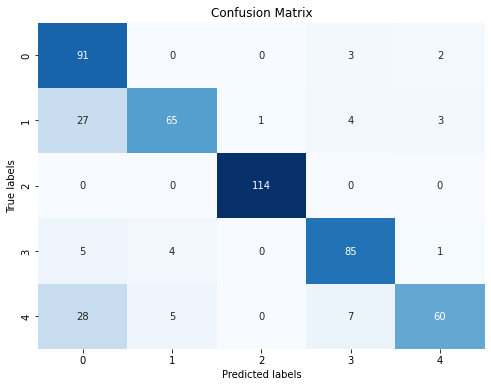

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_classes)
# 히트맵 그리기

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## test 데이터 예측

In [ ]:
test = pd.read_csv('data/custom_test.csv')

In [ ]:
test = test['conversation'].apply(preprocess_sentence)

In [ ]:
test= list(np.stack(test.values))

In [ ]:
inputs_test = tokenizer(test,return_tensors='tf', 
                   padding=True, truncation=True,max_length=maxlen)

In [ ]:
test = tf.multiply(inputs_test.input_ids,inputs_test.attention_mask)

In [ ]:
test[0]

In [ ]:
pred = model.predict(test)

In [ ]:
from collections import Counter
results = []
for p in pred:
    results.append(np.argmax(p))

Counter(results)